Note: This script uses XGBoost, Matplotlib, and Seaborn.
Data loaded successfully.
Starting improved preprocessing...
Removed outliers. New train shape: (1458, 80)
Combined data shape: (2917, 79)
Creating new features...
Applied log transformation to 23 skewed features.
Normalizing data using StandardScaler...
Preprocessing complete. Final data shape: X=(1458, 311), X_test_competition=(1459, 311)

Data split into 70% train, 15% validation, 15% test sets.
Train set size: 1020 (70%)
Validation set size: 219 (15%)
Test set size: 219 (15%)

  Training models for L2 Lambda = 1

--- Final Test Set RMSE (Lambda = 1) ---
LightGBM: 0.11275
XGBoost:  0.10599
Blended:  0.10979

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


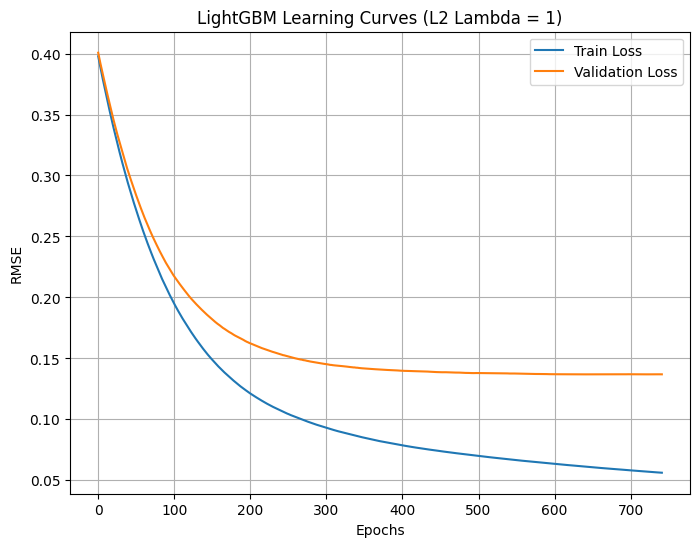


  Training models for L2 Lambda = 50

--- Final Test Set RMSE (Lambda = 50) ---
LightGBM: 0.11643
XGBoost:  0.11216
Blended:  0.11469

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


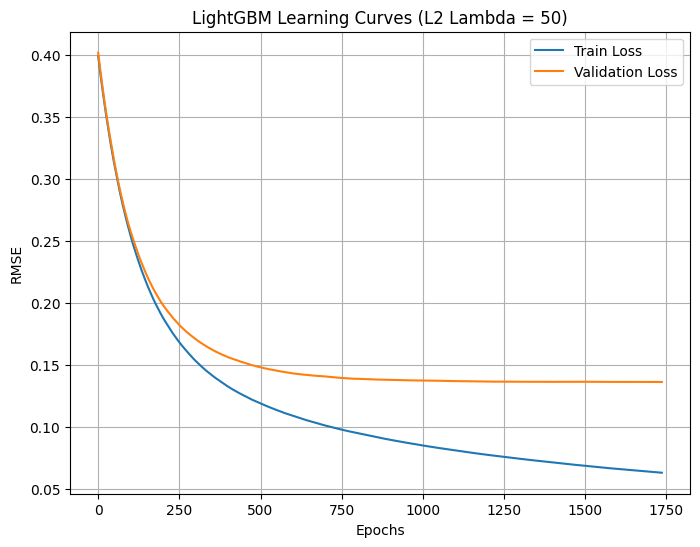


  Training models for L2 Lambda = 100

--- Final Test Set RMSE (Lambda = 100) ---
LightGBM: 0.11681
XGBoost:  0.11354
Blended:  0.11532

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


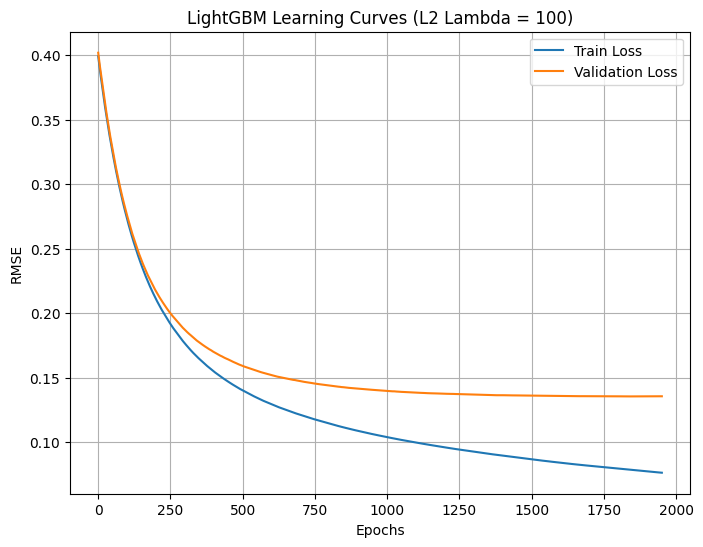


  Training models for L2 Lambda = 200

--- Final Test Set RMSE (Lambda = 200) ---
LightGBM: 0.11969
XGBoost:  0.11851
Blended:  0.11891

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


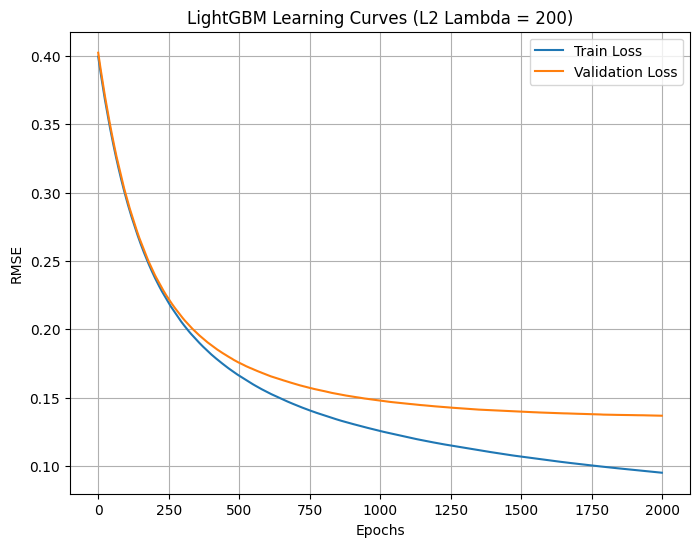


  Training models for L2 Lambda = 300

--- Final Test Set RMSE (Lambda = 300) ---
LightGBM: 0.12342
XGBoost:  0.12416
Blended:  0.12331

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


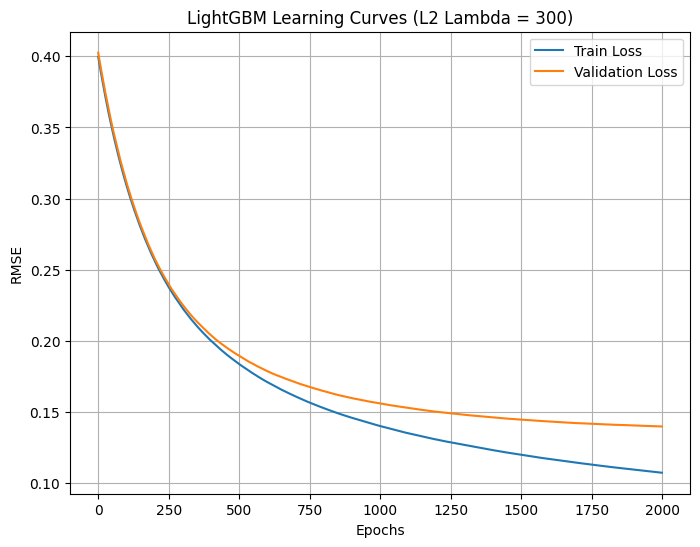


  Training models for L2 Lambda = 400

--- Final Test Set RMSE (Lambda = 400) ---
LightGBM: 0.12873
XGBoost:  0.12915
Blended:  0.12857

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


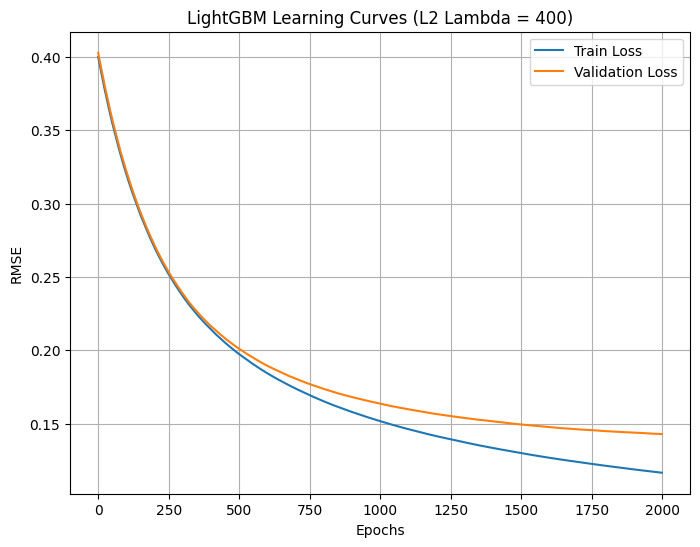


  Training models for L2 Lambda = 500

--- Final Test Set RMSE (Lambda = 500) ---
LightGBM: 0.13401
XGBoost:  0.13436
Blended:  0.13387

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


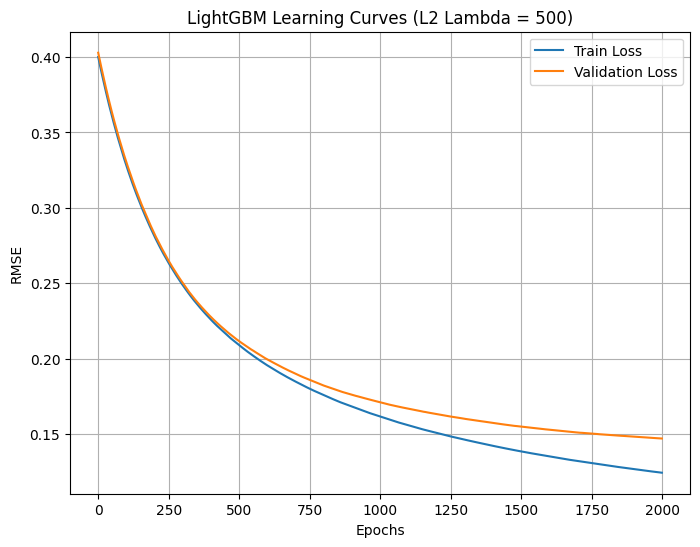

In [26]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Added for normalization
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# --- VISUALIZATION IMPORTS ---
import matplotlib.pyplot as plt
import seaborn as sns

# Add a note for the user about required libraries
print("Note: This script uses XGBoost, Matplotlib, and Seaborn.")


# --- 1. Data Loading ---
def load_data():
    """Loads the training and testing datasets."""
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print("Data loaded successfully.")
        return train_df, test_df
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found.")
        print("Please ensure the data files are in the same directory as the script.")
        return None, None

# --- 2. Preprocessing and Feature Engineering (MODIFIED) ---
def preprocess(train_df, test_df):
    """Handles missing values, feature engineering, and normalization."""
    print("Starting improved preprocessing...")
    test_ids = test_df['Id']
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
    print(f"Removed outliers. New train shape: {train_df.shape}")

    # The target variable is log-transformed, not normalized.
    train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
    y = train_df['SalePrice']

    all_data = pd.concat((train_df.drop('SalePrice', axis=1), test_df))
    print(f"Combined data shape: {all_data.shape}")

    # Fill missing values...
    for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
                'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
        all_data[col] = all_data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd',
                'KitchenQual', 'SaleType', 'Electrical'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    # Feature Engineering...
    print("Creating new features...")
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                                   all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
    all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                                  all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                                  all_data['WoodDeckSF'])
    all_data['YearBuilt_Age'] = all_data['YrSold'] - all_data['YearBuilt']
    all_data['YearRemod_Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
    all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    # Skewness Transform...
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.75].index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    print(f"Applied log transformation to {len(skewed_feats)} skewed features.")

    # One-Hot Encoding...
    all_data = pd.get_dummies(all_data)

    # Separate train and competition test data
    X = all_data[:len(y)]
    X_test_competition = all_data[len(y):]

    # --- NEW: Normalize all features (mean=0, variance=1) ---
    print("Normalizing data using StandardScaler...")
    scaler = StandardScaler()
    
    # Fit the scaler ONLY on the training data to avoid data leakage
    scaler.fit(X)
    
    # Transform both the training and competition test data
    X_scaled = scaler.transform(X)
    X_test_competition_scaled = scaler.transform(X_test_competition)
    
    # Convert scaled arrays back to DataFrames, preserving columns and index
    X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    X_test_competition = pd.DataFrame(X_test_competition_scaled, index=X_test_competition.index, columns=X_test_competition.columns)
    
    print(f"Preprocessing complete. Final data shape: X={X.shape}, X_test_competition={X_test_competition.shape}")
    return X, y, X_test_competition, test_ids


# --- VISUALIZATION FUNCTIONS ---
def plot_learning_curves(lgb_evals, l2_lambda):
    """Plots the training and validation loss for LightGBM for a given lambda."""
    plt.figure(figsize=(8, 6))
    lgb_train_loss = lgb_evals['training']['rmse']
    lgb_val_loss = lgb_evals['valid_1']['rmse']
    plt.plot(lgb_train_loss, label='Train Loss')
    plt.plot(lgb_val_loss, label='Validation Loss')
    plt.title(f'LightGBM Learning Curves (L2 Lambda = {l2_lambda})')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 3. Model Training and Evaluation ---
def train_and_evaluate_for_lambda(l2_lambda, X_train, y_train, X_val, y_val, X_test, y_test):
    """Trains and evaluates models for a specific L2 lambda value."""
    print(f"\n===============================================")
    print(f"  Training models for L2 Lambda = {l2_lambda}")
    print(f"===============================================")
    
    lgb_evals = {}
    
    # --- Train LightGBM Model ---
    lgb_model = lgb.LGBMRegressor(
        objective='regression', metric='rmse', n_estimators=2000,
        learning_rate=0.01, feature_fraction=0.8, bagging_fraction=0.8,
        bagging_freq=1, lambda_l1=0.1, 
        lambda_l2=l2_lambda,
        num_leaves=31, verbose=-1, n_jobs=-1, seed=42
    )
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                  eval_metric='rmse', 
                  callbacks=[lgb.early_stopping(100, verbose=False),
                             lgb.record_evaluation(lgb_evals)])

    # --- Train XGBoost Model ---
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', eval_metric='rmse', n_estimators=2000,
        learning_rate=0.01, max_depth=4, subsample=0.8,
        colsample_bytree=0.8, 
        reg_lambda=l2_lambda,
        random_state=42, n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                  verbose=False)

    # --- Evaluate on the Hold-Out Test Set ---
    preds_lgb = lgb_model.predict(X_test)
    preds_xgb = xgb_model.predict(X_test)
    blended_preds = 0.7 * preds_lgb + 0.3 * preds_xgb
    
    rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb))
    rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
    rmse_blended = np.sqrt(mean_squared_error(y_test, blended_preds))
    
    print(f"\n--- Final Test Set RMSE (Lambda = {l2_lambda}) ---")
    print(f"LightGBM: {rmse_lgb:.5f}")
    print(f"XGBoost:  {rmse_xgb:.5f}")
    print(f"Blended:  {rmse_blended:.5f}")
    
    # --- Visualize Results ---
    print("\nNote: Plotting learning curves for LightGBM only due to XGBoost environment conflict.")
    plot_learning_curves(lgb_evals, l2_lambda)

# --- Main Execution ---
if __name__ == '__main__':
    train_df, test_df = load_data()
    if train_df is not None and test_df is not None:
        X, y, X_test_competition, test_ids = preprocess(train_df, test_df)
        
        # --- MODIFIED: Create the 70-15-15 split ---
        # First, split into 70% train and 30% temporary (val + test)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        # Split the 30% temporary set in half to get 15% validation and 15% test
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        print("\nData split into 70% train, 15% validation, 15% test sets.")
        print(f"Train set size: {len(X_train)} ({len(X_train)/len(X)*100:.0f}%)")
        print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.0f}%)")
        print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.0f}%)")
        
        lambdas = [1, 50, 100, 200, 300, 400, 500]
        for l2_lambda in lambdas:
            train_and_evaluate_for_lambda(l2_lambda, X_train, y_train, X_val, y_val, X_test, y_test)